## Bike Sharing Data Set
    
### Predicting hourly bike rental count based on the environmental & seasonal settings

### Data Dictonary

1. instant - Record Index
2. dteday - Date (Format: YYYY-MM-DD)
3. season - Season (1: springer, 2: summer, 3: fall, 4: winter)
4. yr - Year (0: 2011, 1:2012)
5. mnth - Month (1 to 12)
6. hr - Hour (0 to 23)
7. holiday - Weather day is holiday or not
8. weekday - Day of the week
9. workingday - If day is neither weekend nor holiday is 1, otherwise is 0
10. weathersit - Weather situation (1: Clear, Few   clouds, Partly cloudy, Partly cloudy; 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist; 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)
11. temp - Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39
12. atemp - Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50
13. hum - Normalized humidity. The values are divided to 100 (max)
14. windspeed - Normalized wind speed. The values are divided to 67 (max)
15. casual - Count of casual users
16. registered - Count of registered users
17. cnt - Count of total rental bikes including both casual and registered

### Important points to keep in mind:

1. The metric used throughout this notebook to evaluate models is accuracy, which in regression terms refers to the coefficient of determination R^2, which is defined as the amount of variation in the dependent variable that is explained by the explanatory variables used.
2. Every model uses cross validation with a 5-fold split to train, and the average of each fold is taken as a final accuracy for the model.
3. A grid search has been implemented wherever necessary through nested for loops to find the best parameters for each model.
4. It is important to note that the continuous variables temp, atemp, hum and windspeed have already been scaled, so no further scaling is necessary

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading in the dataframe

In [2]:
df = pd.read_csv('Bike Rental Dataset.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


### Checking for any missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


#### There are no missing values in this dataset.
#### Since one of the requirements is that the dataset have 5% - 10% missing values, we shall proceed to randomly impute NotANumber (NaN) values throughout.

In [4]:
df = df.mask(np.random.random(df.shape) < .0485)

#### Now let us check the percentage of missing values in the dataset

In [5]:
df.isna().sum().sum()/df.count().sum() * 100

5.077035793546918

#### Roughly 5.08% of the datapoints been deleted, which meets the requirement.
#### Let's proceed to drop these rows from the dataset. The reason why we are dropping these rows instead of imputing values is to reduce the size of the dataset for computation. Models such as kernel SVM are bad at scaling to many data points and as a result, are computationally intensive and take longer than average to spit out a result.

In [6]:
df.dropna(inplace=True)

#### Checking the data again for uniformity

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 6 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     7453 non-null   float64
 1   dteday      7453 non-null   object 
 2   season      7453 non-null   float64
 3   yr          7453 non-null   float64
 4   mnth        7453 non-null   float64
 5   hr          7453 non-null   float64
 6   holiday     7453 non-null   float64
 7   weekday     7453 non-null   float64
 8   workingday  7453 non-null   float64
 9   weathersit  7453 non-null   float64
 10  temp        7453 non-null   float64
 11  atemp       7453 non-null   float64
 12  hum         7453 non-null   float64
 13  windspeed   7453 non-null   float64
 14  casual      7453 non-null   float64
 15  registered  7453 non-null   float64
 16  cnt         7453 non-null   float64
dtypes: float64(16), object(1)
memory usage: 1.0+ MB


#### Now let's delete those columns which are no longer needed. Let's first explore the reasons why these columns are unnecessary.
1. instant - This is nothing but a serial number or index, with unique values for each entry and hence, cannot be used to predict anything.
2. dteday - While this variable is a date and has the potential to be useful, the information that it conveys is already captured by other variables in the dataset, and has therefore been dropped.
3. Adding casual + registered users gives us the total count('cnt'). As a result, any model which includes these 2 variables will give 100% accuracy all the time.

In [8]:
df.drop(['instant', 'dteday', 'casual', 'registered'], axis = 1, inplace = True)

### Let's proceed to one hot code the categorical variables.
While an argument can be made that some of these variables can be treated as ordinal, it makes more sense to one hot code them as otherwise, there is a risk that the model will end up treating them as continuous. Also, the total number of columns that ends up being generated is not too many compared to the number of rows in the dataset, and we can hence be more sure of our estimates and reduce the chance of overfitting.

In [9]:
cols = pd.get_dummies(df['mnth'], prefix = 'month')
df[cols.columns] = cols
df.drop('mnth', axis = 1, inplace = True)

In [10]:
cols = pd.get_dummies(df['season'], prefix = 'season')
df[cols.columns] = cols
df.drop('season', axis = 1, inplace = True)

In [11]:
cols = pd.get_dummies(df['weathersit'], prefix = 'weather_situation')
df[cols.columns] = cols
df.drop('weathersit', axis = 1, inplace = True)

In [12]:
cols = pd.get_dummies(df['weekday'], prefix = 'day_of_week')
df[cols.columns] = cols
df.drop('weekday', axis = 1, inplace = True)

In [13]:
cols = pd.get_dummies(df['hr'], prefix = 'hour_of_day')
df[cols.columns] = cols
df.drop('hr', axis = 1, inplace = True)

#### Let's take a final look at the number of features in our dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 6 to 17378
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     7453 non-null   float64
 1   holiday                7453 non-null   float64
 2   workingday             7453 non-null   float64
 3   temp                   7453 non-null   float64
 4   atemp                  7453 non-null   float64
 5   hum                    7453 non-null   float64
 6   windspeed              7453 non-null   float64
 7   cnt                    7453 non-null   float64
 8   month_1.0              7453 non-null   uint8  
 9   month_2.0              7453 non-null   uint8  
 10  month_3.0              7453 non-null   uint8  
 11  month_4.0              7453 non-null   uint8  
 12  month_5.0              7453 non-null   uint8  
 13  month_6.0              7453 non-null   uint8  
 14  month_7.0              7453 non-null   uint8  
 15  mon

#### Designating 'cnt' as the target and the rest as explanatory variables

In [15]:
X = df.drop('cnt', axis = 1)
y = df['cnt']

### Using the Cross Validation library from scikit-learn

In [16]:
from sklearn.model_selection import cross_val_score

#### Now that all preprocessing is done, let's try out various models under different hyperparameters.

### Model 1: Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
lreg = LinearRegression()
scores = cross_val_score(lreg, X, y)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.54


#### Linear Regression gives us a decent score of 0.54

### Model 2: Ridge Regression

In [24]:
from sklearn.linear_model import Ridge

Text(0.5, 0, 'alpha_values')

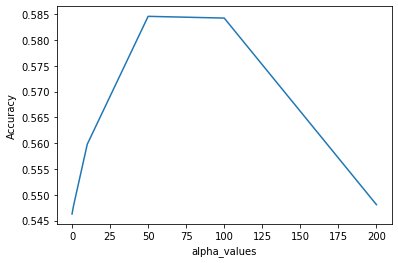

In [25]:
accuracy = []
alpha_values = [200, 100, 50, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alpha_values:
    ridge = Ridge(alpha, max_iter = 100000)
    scores = cross_val_score(ridge, X, y)
    accuracy.append(scores.mean())
plt.plot(alpha_values, accuracy)
plt.ylabel("Accuracy")
plt.xlabel("alpha_values")

#### Looks like an alpha value of 50 gives the best accuracy in the ridge regression model (approximately 0.59)

### Model 3: Lasso Regression

In [26]:
from sklearn.linear_model import Lasso

Text(0.5, 0, 'alpha_values')

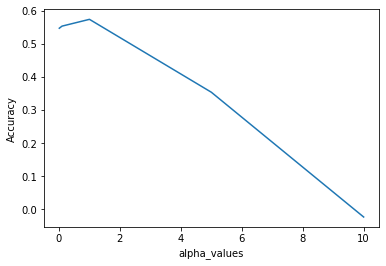

In [27]:
accuracy = []
alpha_values = [10, 5, 1, 0.1, 0.01]

for alpha in alpha_values:
    lasso = Lasso(alpha, max_iter = 100000)
    scores = cross_val_score(lasso, X, y)
    accuracy.append(scores.mean())
plt.plot(alpha_values, accuracy)
plt.ylabel("Accuracy")
plt.xlabel("alpha_values")

#### An alpha value of 1 gives the best accuracy of roughly 0.58 for the Lasso Regression model

### Model 4: KNN Regressor

In [28]:
from sklearn.neighbors import KNeighborsRegressor

Text(0.5, 0, 'n_neighbors')

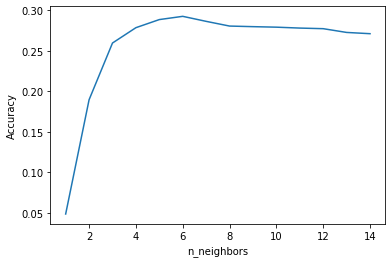

In [29]:
accuracy = []
neighbors_settings = range(1, 15)

for n_neighbors in neighbors_settings:
    knn = KNeighborsRegressor(n_neighbors = n_neighbors)
    scores = cross_val_score(knn, X, y)
    accuracy.append(scores.mean())
plt.plot(neighbors_settings, accuracy)
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")

#### The KNN regressor gives us terrible accuracy and we therfore shall not be using this model.

### Model 5: Decision Tree Regressor

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
max_depth_settings = np.linspace(1, 50, 50, endpoint=True)
min_samples_split_settings = np.linspace(0.001, 0.01, 100, endpoint=True)
best_score = 0
for max_depth in max_depth_settings:
    for min_samples_split in min_samples_split_settings:
        tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
        score = cross_val_score(tree, X, y).mean()
        if score > best_score:
            best_score = score
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            
print('The parameters which give the best score of {:.3f}'.format(best_score),
      'are max_depth:',best_max_depth,'and min_samples_split:',best_min_samples_split)

The parameters which give the best score of 0.583 are max_depth: 25.0 and min_samples_split: 0.0035454545454545456


#### Decision Tree so far has given us the best accuracy of any model for this dataset.

### Model 6: Linear Support Vector Regressor

In [32]:
from sklearn.svm import LinearSVR

Text(0.5, 0, 'c_values')

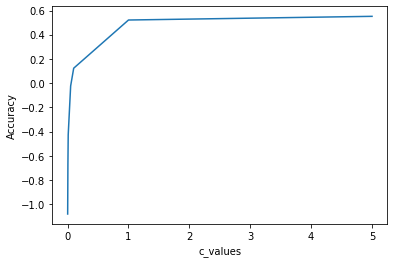

In [33]:
accuracy = []
C_settings = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5]
for C in C_settings:
    lsvr = LinearSVR(C = C, max_iter = 100000)
    scores = cross_val_score(lsvr, X, y)
    accuracy.append(scores.mean())
plt.plot(C_settings, accuracy)
plt.ylabel("Accuracy")
plt.xlabel("c_values")

#### The Linear SVR gives us decent accuracy, but the Decision Tree is still the best performing algorithm.

### Model 7: Kernelized Support Vector Regression

In [34]:
from sklearn.svm import SVR

#### (i) Using rbf kernel

In [35]:
C_settings = [50000, 100000]
best_score = 0

for C in C_settings:
    ksvr = SVR(kernel = 'rbf', C = C, epsilon = 10)
    score = cross_val_score(ksvr, X, y).mean()
    if score > best_score:
        best_score = score
        best_C = C
            
print('The parameter which gives the best score of {:.3f}'.format(best_score),'is C:',best_C)

The parameter which gives the best score of 0.804 is C: 50000


#### (ii) Using linear kernel

In [36]:
C_settings = [1, 25, 50]
epsilon_settings = [1, 5, 10]
best_score = 0

for C in C_settings:
    for epsilon in epsilon_settings:
        ksvr = SVR(kernel = 'linear', C = C, epsilon = epsilon)
        score = cross_val_score(ksvr, X, y).mean()
        if score > best_score:
            best_score = score
            best_C = C
            best_epsilon = epsilon
            
print('The parameters which give the best score of {:.3f}'.format(best_score),
      'are C:',best_C,'and epsilon:',best_epsilon)

The parameters which give the best score of 0.531 are C: 25 and epsilon: 10


#### (iii) Using Polynomial kernel

In [37]:
C_settings = [1, 25, 50]
epsilon_settings = [0.1, 1, 5]
best_score = 0

for C in C_settings:
    for epsilon in epsilon_settings:
        ksvr = SVR(kernel = 'poly', C = C, epsilon = epsilon)
        score = cross_val_score(ksvr, X, y).mean()
        if score > best_score:
            best_score = score
            best_C = C
            best_epsilon = epsilon
            
print('The parameters which give the best score of {:.3f}'.format(best_score),
      'are C:',best_C,'and epsilon:',best_epsilon)

The parameters which give the best score of 0.825 are C: 50 and epsilon: 1


#### Support vector regression with the polynomial kernel, a high of C = 50 and epsilon = 5 has given the best accuracy so far. 

### Model 8: Polynomial Regression

In [38]:
from sklearn.preprocessing import PolynomialFeatures

Text(0.5, 0, 'Polynomial Degree')

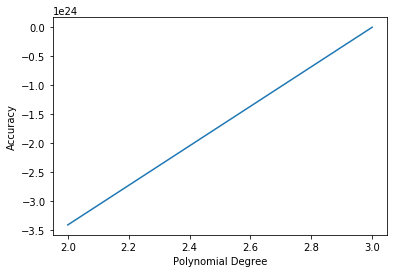

In [39]:
degree_settings = [2, 3]
accuracy = []

for degree in degree_settings:
    poly = PolynomialFeatures(degree = degree)
    X_poly = poly.fit_transform(X)
    poly_reg = LinearRegression()
    scores = cross_val_score(poly_reg, X_poly, y)
    accuracy.append(scores.mean())
plt.plot(degree_settings, accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Polynomial Degree")

#### It looks like Polynomial Regression gives us terrible accuracy regardless of degree, so we won't be using this.
#### We can conclude that a support vector machine is the best algorithm to use for this regression.

### We have narrowed down on the support vector regression model with a polynomial kernel, C = 50 and epsilon = 1. This has given us a cross validation accuracy of 0.825 throughout the dataset, so this is the final model we will be using.

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)
svr = SVR(kernel = 'poly', C = 50, epsilon = 5)
svr.fit(X_train, y_train)

print('Train score: {:.3f}'.format(svr.score(X_train, y_train)))
print('Test score {:.3f}'.format(svr.score(X_test, y_test)))

Train score: 0.942
Test score 0.903


#### As can be seen above, the model not only fits very well to the training data but also generalizes to the test set. The difference between training and test score is low enough to conclude that this falls within a reasonable margin of error, and this is therefore the best model for predicting bicycle rentals using environmental conditions.